In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/trial0.csv', index_col='time')

# omit first 100 due to errors in setting up apparatus in beginning
df = df.iloc[100:]

SR = 25

Text(0.5, 0, 'time (s)')

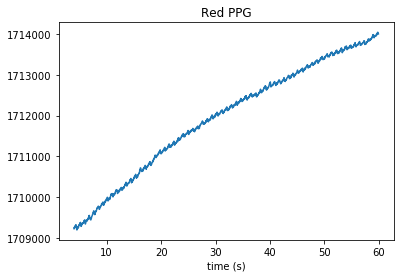

In [2]:
plt.plot(df['Reflect: Red']);
plt.title('Red PPG')
plt.xlabel('time (s)')

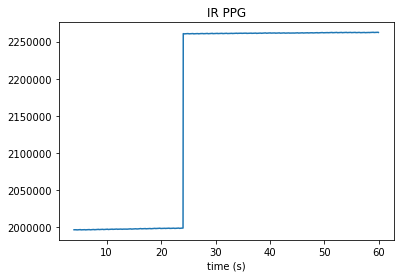

In [3]:
plt.plot(df['Reflect: IR']);
plt.title('IR PPG')
plt.xlabel('time (s)');

In [4]:
from pyts import decomposition
import heartpy as hp

def extract_acdc(F, L, SR):
    """
    F: time series numpy array of PPG signal
    
    Returns: 
    ac_signal
    dc_signal
    """
    ssa = decomposition.SingularSpectrumAnalysis(window_size = L)
    F_ssa = ssa.fit_transform(F.reshape(1, -1))
    dc = F_ssa[0]
    ac = np.sum(F_ssa[1:], axis=0)
    filtered_ac = hp.filter_signal(ac, 
                                  cutoff = [.7, 3.5], 
                                  filtertype = 'bandpass',
                                  sample_rate = SR, 
                                  order = 4,
                                  return_top = False)
    return dc, filtered_ac

def rms(ac_signal):
    return np.sqrt(np.mean(ac_signal ** 2))

def linear_spo2(red_ac, red_dc, ir_ac, ir_dc):
    # get rms values
    red_rms = rms(red_ac)
    red_amp = np.sqrt(2) * red_rms
    ir_rms = rms(ir_ac)
    ir_amp = np.sqrt(2) * ir_rms
    
    # calculate R
    redRatio = (red_amp * 2) / np.mean(red_dc - red_amp)
    irRatio = (ir_amp * 2) / np.mean(ir_dc - ir_amp)
    R = redRatio / irRatio

    # linear fit
    lin_spo2 = 104 - 17 * R
    return lin_spo2

def quadratic_spo2(red_ac, red_dc, ir_ac, ir_dc):
    # get rms values
    red_rms = rms(red_ac)
    red_amp = np.sqrt(2) * red_rms
    ir_rms = rms(ir_ac)
    ir_amp = np.sqrt(2) * ir_rms
    
    # calculate R
    redRatio = (red_amp * 2) / np.mean(red_dc - red_amp)
    irRatio = (ir_amp * 2) / np.mean(ir_dc - ir_amp)
    R = redRatio / irRatio

    # using quadratic fit
    a = 1.5958422
    b = -34.6596622
    c = 112.6898759
    quad_spo2 = a * (R**2) + b * R + c
    return quad_spo2

In [5]:
real_spo2 = []
lin_spo2 = []
quad_spo2 = []

for i in range(df.shape[0] // 100):
    # pull out 100 samples as a single trial
    df_trial = df.iloc[i * 100 : (i + 1) * 100]
    real_spo2.append(df_trial['spo2'].mean())
    L = 50
    
    # red analysis
    red_F = df_trial['Reflect: Red'].to_numpy()
    red_dc, red_ac = extract_acdc(red_F, L, SR)
    
    # ir analysis
    ir_F = df_trial['Reflect: IR'].to_numpy()
    ir_dc, ir_ac = extract_acdc(ir_F, L, SR)

    lin_spo2.append(linear_spo2(red_ac, red_dc, ir_ac, ir_dc))
    quad_spo2.append(quadratic_spo2(red_ac, red_dc, ir_ac, ir_dc))

Text(0.5, 1.0, 'SpO2')

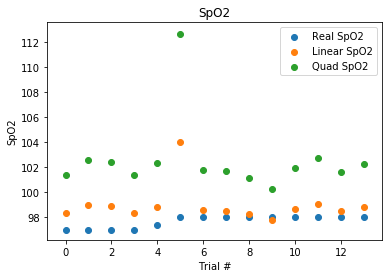

In [6]:
columns = {'real_spo2' : real_spo2, 'lin_spo2' : lin_spo2, 'quad_spo2' : quad_spo2}
results = pd.DataFrame(columns)
results.rename_axis(index='trials')
plt.scatter(results.index, results['real_spo2'])
plt.scatter(results.index, results['lin_spo2'])
plt.scatter(results.index, results['quad_spo2'])
plt.legend(['Real SpO2', 'Linear SpO2', 'Quad SpO2'])
plt.xlabel('Trial #')
plt.ylabel('SpO2')
plt.title('SpO2')

In [7]:
# looking at error
results['lin_error'] = abs((results.lin_spo2 - results.real_spo2) / results.real_spo2)
results['quad_error'] = abs((results.quad_spo2 - results.real_spo2) / results.real_spo2)

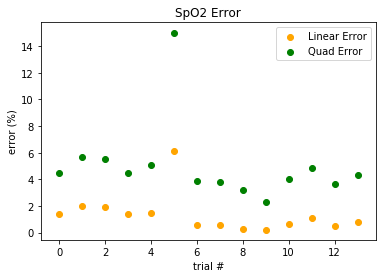

In [8]:
plt.scatter(results.index, results.lin_error * 100, color='orange')
plt.scatter(results.index, results.quad_error * 100, color='g')
plt.title('SpO2 Error')
plt.xlabel('trial #')
plt.ylabel('error (%)')
plt.legend(['Linear Error', 'Quad Error'])